This file extract the data from an experiment folder and create a file with the obtained information

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os.path
import glob
import pickle as pkl

#modify some matplotlib parameters to manage the images for illustrator
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from skimage.filters import gaussian
import skimage.feature as skfeat
from scipy import ndimage

### Load Images

In [9]:
## Fill this two variables accord the files of interest
im_extension = 'tiff'
nested_folder = 'test_images/R1 24h/'

In [93]:
print('folder "' +fpath.split('\\')[-1])

folder "R1 24h


In [10]:
fpath = os.path.abspath(nested_folder)

im_names, fnames = file_names(fpath,im_extension)

D:\Github\Colony_correlations\codes\test_images\R1 24h

folder "R1 24h" = 5 files

file names:
['dapidiidio-540-Profundidad de enfoque extendida-01brightfield.tiff', 'dapidiidio-540-Profundidad de enfoque extendida-01completo.tiff', 'dapidiidio-540-Profundidad de enfoque extendida-01dapi.tiff', 'dapidiidio-540-Profundidad de enfoque extendida-01dii.tiff', 'dapidiidio-540-Profundidad de enfoque extendida-01dio.tiff']


#### Get image data

Next box load and organize the image data of the images in the folder

In [11]:
im_data={}
im_data['R'],im_data['G'],im_data['B'],im_data['NormSum'] = get_im_data(fnames)
im_data['name']=fnames     # to store the related image source
# also define a vector with the channels
CHANNELS=['R','G','B']

Use next box to explore the channel values of a selected image

D:\Github\Colony_correlations\codes\test_images\R1 24h\dapidiidio-540-Profundidad de enfoque extendida-01dapi.tiff


()

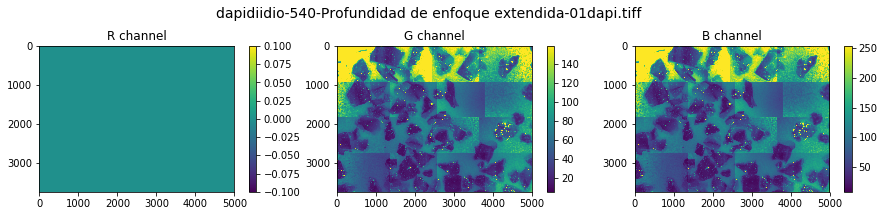

In [12]:
im_number = 2
plot_channels(im_data, im_number)

#### Detect bacterial colonies on each of them

In [18]:
#initialize the dictionaries to store the data
sImS = {}
sImSall = {}
detected={}
filter_sigma = {}
threshold = {}
sigma_lim = {}

 #### Execute the next three boxes to perform the analysis over each image
 (repeat for each of them)

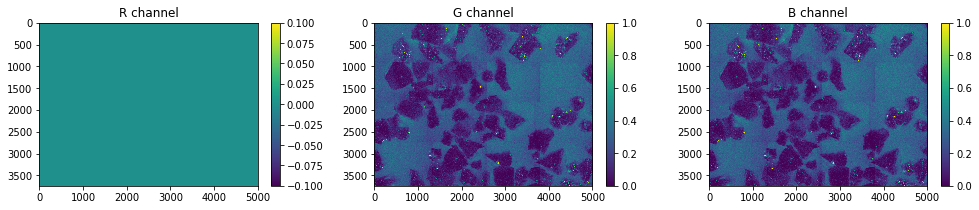

In [25]:
#Fill this two variables to set the filter properties
im_num = 4
filter_sigma[im_num] = 0.5

#### apply the filter
sImS[im_num],sImSall[im_num] = smooth_data(im_data,filter_sigma[im_num],im_num)

found 1209 colonies


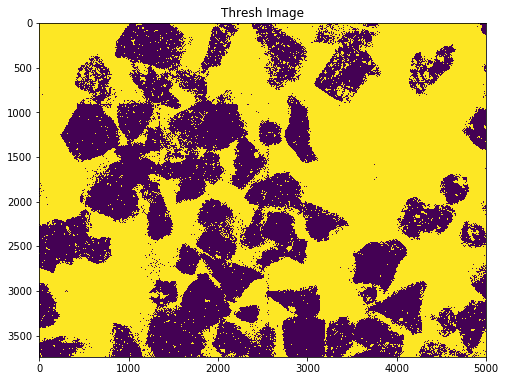

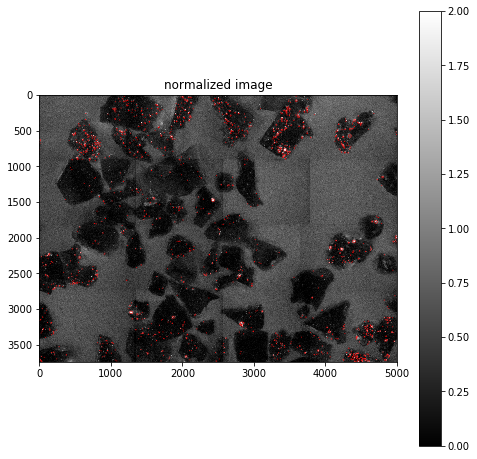

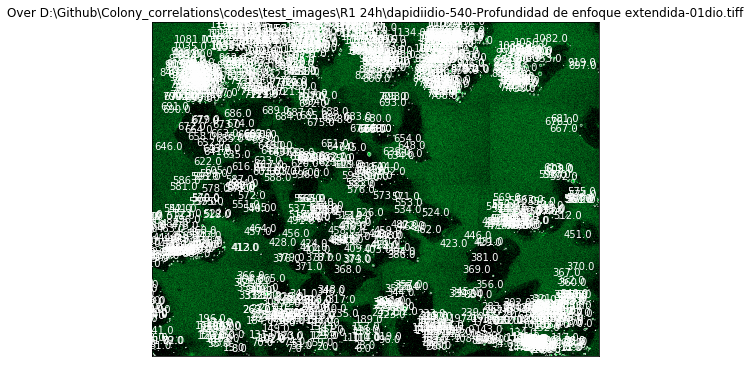

In [26]:
## Fill this two parameters to define the colony identification
threshold[im_num]=0.35
sigma_lim[im_num] = [2,14]

## Fill this two parameters only if you want to use a smaller region of the image
x_lim = [0,-1]
y_lim = [0,-1]

#########################
### detect the images ###
#########################

detected[im_num]=colony_blobs_id(sImSall[im_num], threshold[im_num], fnames[im_num], sigma_lim[im_num])#, xlim=x_lim, ylim=y_lim) 

Whith the next box, you are able to perform a zoom over the image to check the detected colonies quality

()

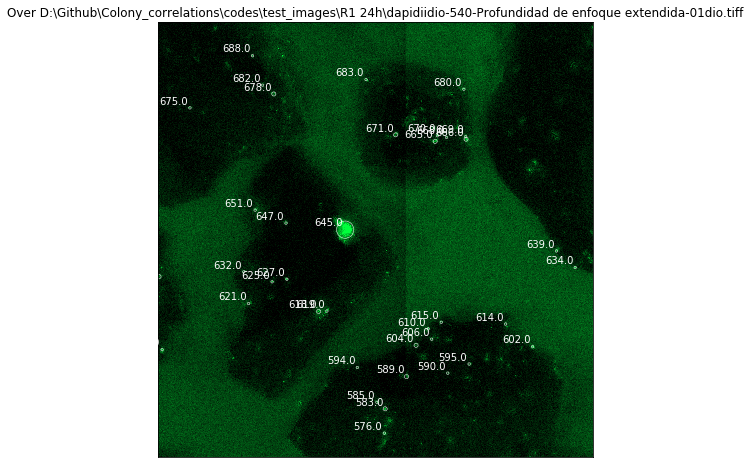

In [27]:
y_zoom = [1000,2000]
x_zoom = [2000,3000]
colony_plot(detected[im_num], fnames[im_num], y_zoom, x_zoom)

### BrightField filter

#### Smooth the image

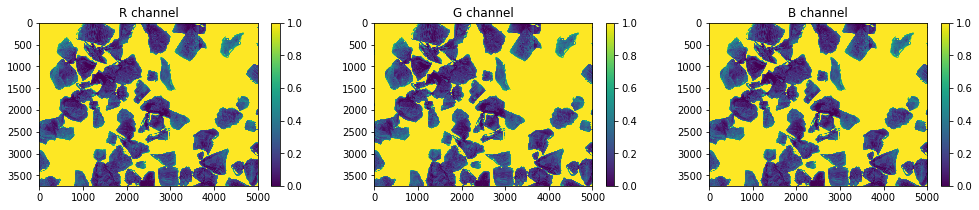

In [29]:
# fill this two variables with the BrigthField image number and desired filter parameter value
im_num = 0
filter_sigma[im_num] = 0.5

# Apply the filter
sImS[im_num],sImSall[im_num] = smooth_data(im_data,filter_sigma[im_num],im_num)

#### Determine the grain area

In [74]:
bf_cols = {}

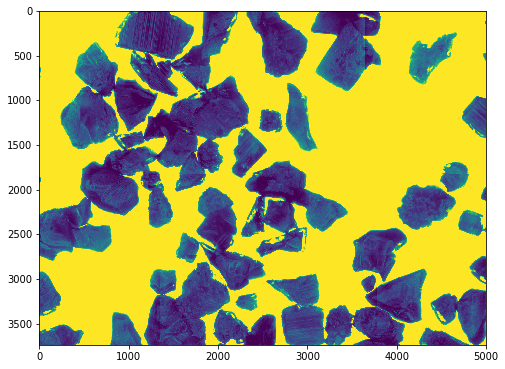

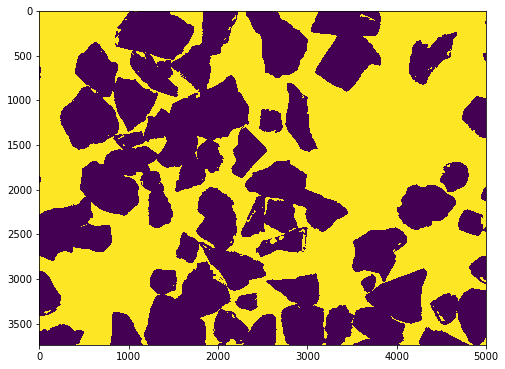

In [75]:
bf_thresh = 2.9

bf_cols["bf_threshold"] = bf_thresh
bin_bf = binary_image(sImSall[im_num], bf_thresh)

####  Filter the colonies outside the grains
execute the next box for any image desired to consider only the colonies inside the grains

In [80]:
im_num = 4
bf_cols[im_num] =  np.asarray(Bfield_filter(detected[im_num], bin_bf))

Next two boxes couls be used to compare the situtation with or without the colonies outside the grains

()

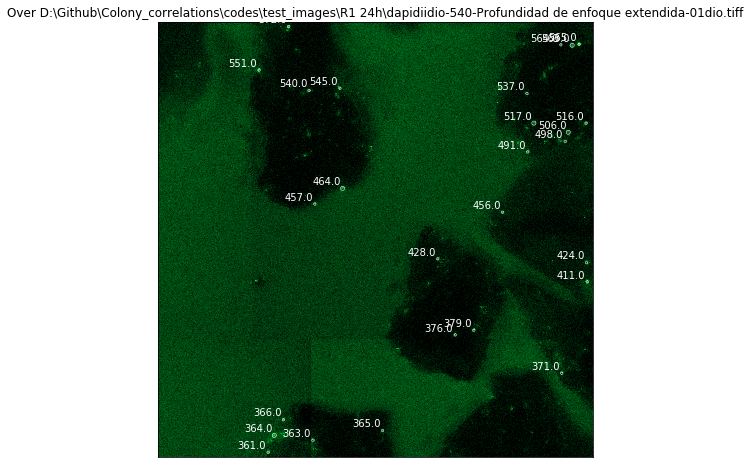

In [83]:
colony_plot(bf_cols[im_num], fnames[im_num], ylim=[2000,3000], xlim=[1000,2000])

()

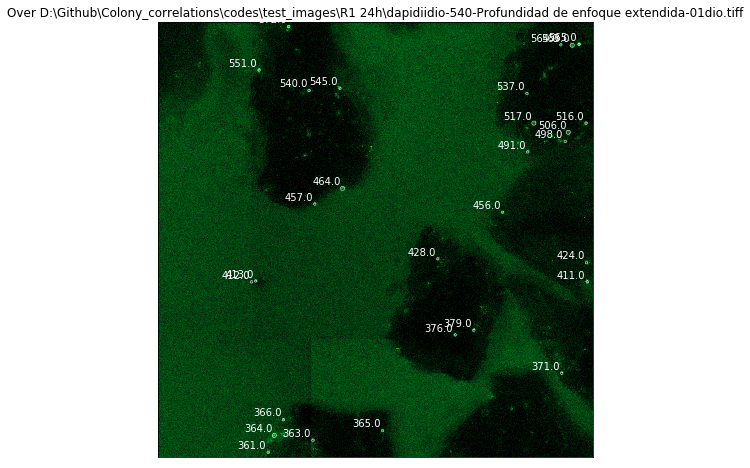

In [84]:
colony_plot(detected[im_num], fnames[im_num], ylim=[2000,3000], xlim=[1000,2000])

### Save the folder images data in the database

In [120]:
### Organize the information, it is not necessary to modify anything here.
images_data = {}
images_data["smooth"]={}
images_data["smooth"]['images'] = sImS
images_data["smooth"]['filter_sigma'] = filter_sigma
images_data["detection"] = {}
images_data["detection"]['colonies'] = detected
images_data["detection"]['threshold'] = threshold
images_data["detection"]['sigma_domain'] = sigma_lim
images_data["detection"]['bf_colonies'] = bf_cols

In [123]:
#Save the object
save_obj(images_data, 'database', 'data', fpath)

there was any previous file
"database.pkl" saved on folder "data"


## Functions

In [2]:
def file_names(path,file_type):
    """
    To obtain a list with the name of the files with defined extension (filetype) on a certain folder (path)

    Parameters
    ----------
    path : string
        folder name where the images are stored

    file_type : string
        extension of the files to search for (e.g. tif, png, jpg)

    Returns
    -------
    F_Names : list
        number of defined filetype files on the path folder

    """
    
    Names = []
    for name in os.listdir(path):
        if name.find(file_type) != -1:
            Names.append(name)
    
    #display information
    print(path+ '\n')

    im_count = len(Names)
    im_fnames = []

    for name in Names:
        im_fnames.append(os.path.join(path, name))

    print('folder "' +path.split('\\')[-1]+'" = '+str(im_count) + ' files' + '\n')
    print('file names:')
    print(Names)
            
    return(Names, im_fnames)


In [3]:
def get_im_data(f_names):
    """
    Load image data from a list of image files (f_names).
    It doesn't supports images with different pixel dimentions
    (e.g all of them have to be 900x600 px)
    It is important for further positional correlations

    Parameters
    ----------
    f_name : string
        file name including full path where images are stored, e.g. "/folder/image_1.jpg"

    Returns
    -------
    ImsR,ImsG,ImsB: array_like
        data per channel of each image (ImsR -> matrix size = (W,H,image_count/x_frames))

    """
    
    W,H,_ = plt.imread(f_names[0]).shape      # Measure the image size based on the first image on the folder
    N = len(f_names)
    Ims_R = np.zeros((W,H,N))
    Ims_G = np.zeros((W,H,N))
    Ims_B = np.zeros((W,H,N))
    Ims_Sum = np.zeros((W,H,N))
    
    for i in range(N):
        Im = plt.imread(f_names[i])
        Ims_R[:,:,i] = Im[:,:,0]              # Last number code the channel: 0=red, 1=green, 2=blue
        Ims_G[:,:,i] = Im[:,:,1]
        Ims_B[:,:,i] = Im[:,:,2]
        
        Chan_Sum = np.sum(Im, axis=2) #sum channels
        max_imValue = np.amax(Chan_Sum, axis = (0,1)) #get the maximum im value
        
        if max_imValue < 1: #make sure it is higher than 1 to avoid division problems
            max_imValue = 1
            
        Ims_Sum[:,:,i] = Chan_Sum*255/max_imValue #normalize and store the value
    
    return(Ims_R,Ims_G,Ims_B,Ims_Sum)

# at call you can take only the channels you are interested in (e.g.):
# red,_,blue=get_im_data(f_names)  ---> this only takes the red and blue channels



In [4]:
def plot_channels(data, image_number):

    """
    plot channels of a desired image data in the dictionary

    Parameters
    ----------
    data: dictionary
        4 dimensional (R,G,B, im_file_number) matrix with the data 
    
    image_number: int
        number of the image in the array data

    Returns
    -------


    """
    
    plt.figure(figsize=(16,3))
    POS_VECT = [131,132,133]           # figure position vector
    count = 0
    plt.suptitle(data['name'][image_number].split('\\')[-1], fontsize=14)
    #print(data['name'][image_number].split('\\')[-1])
    
    for c in CHANNELS:

        # make plot of the sum over time of smoothed data per channel
    
        plt.subplot(POS_VECT[count])
        plt.imshow(data[c][:,:,image_number])
        plt.colorbar()
        plt.title(c+' channel')
    
        count += 1
    plt.subplots_adjust(hspace=0, wspace=0, top=0.8)

    return()

In [5]:
def colony_blobs_id(data, thresh, im_name, sigma_lim=[1,10], filename='null', xlim='null', ylim='null'):
    """
    Use skimage to identify the position of each colony and define the circular region
    used by each of them

    Parameters
    ----------
    data: array of single channel image data

    thresh:
        Pixel values > thresh are included in the analysis, range (0,1)
        
    im_name:
        Name of an image on which to overlay colony positions and sizes
    
    filename: string
        filename with whom save the output image+blobs+ID
    
    sigma_lim: list
        list with lower and upper sigma limits [min_sigma, max_sigma]

    Returns
    -------
    A: array (Nx3)
        Contains the (y,x) position and size of each blob for each of N colonies detected
    """
    
    #Show thresholded image
    plt.figure(figsize=(8,8))
    plt.imshow(data>thresh)
    plt.title('Thresh Image')
    
    if xlim != 'null' and ylim != 'null':
        data2 = data[ylim[0]:ylim[1],xlim[0]:xlim[1]]
    else:
        data2 = data  #this is necesary to avoid conflicts in plot_blobs dimetions
    
    # Find the blobs
    A = skfeat.blob_log(data2, min_sigma=sigma_lim[0], max_sigma=sigma_lim[1], num_sigma=10, 
                    threshold=thresh, overlap=0.2)
    # A =[y,x,sigma]
    col_values = np.zeros((A.shape[0],A.shape[1]+2))
    col_values[:,0:3] = A
        
    radii = ((2)**(1/2))*col_values[:,2]
    col_values[:,3] = radii   # store the radii
    
    col_values[:,4]=np.arange(col_values.shape[0])  #assign the ID column
    
    #make plots
    plot_blobs(col_values, data, ylim, xlim)
    colony_plot(col_values,im_name, ylim, xlim)

    if filename != 'null':
        plt.savefig(str(filename) + ".pdf", transparent=True)

    return(col_values)

#col_values = [x,y,sigma, radii, col_ID]

In [6]:
def plot_blobs(colonies, data, ylim='null', xlim='null'):
    
    if xlim != 'null' and ylim != 'null':
        data = data[ylim[0]:ylim[1],xlim[0]:xlim[1]]  #2 dim data --> R or G or B or sum of them
        colonies = colonies[colonies[:,1]<xlim[1],:]
        colonies = colonies[colonies[:,1]>xlim[0],:]
        colonies = colonies[colonies[:,0]<ylim[1],:]
        colonies = colonies[colonies[:,0]>ylim[0],:]
        colonies[:,1] = colonies[:,1]-xlim[0]
        colonies[:,0] = colonies[:,0]-ylim[0]
    
    xpos=colonies[:,1]
    ypos=colonies[:,0]
    #radii = ((2)**(1/2))*col_sig
    radii = colonies[:,3]
    
    fig_norm = plt.figure(figsize=(8,8))
    plt.imshow(data, cmap='gray')
    plt.colorbar()
    plt.title('normalized image')
    print('found ' + str(len(colonies))+' colonies')
    for i in range(len(colonies)):
        circle = plt.Circle((xpos[i], ypos[i]), radii[i], color='r', fill=False , 
                            lw=0.5)
        fig = plt.gcf()
        ax = fig.gca()
        ax.add_artist(circle)

    return()

In [7]:
def colony_plot(colonies,im_name, ylim, xlim):
    
    if xlim != 'null' and ylim != 'null':
        im = plt.imread(im_name)[ylim[0]:ylim[1],xlim[0]:xlim[1],:]
        colonies = colonies[colonies[:,1]<xlim[1],:]
        colonies = colonies[colonies[:,1]>xlim[0],:]
        colonies = colonies[colonies[:,0]<ylim[1],:]
        colonies = colonies[colonies[:,0]>ylim[0],:]
        colonies[:,1] = colonies[:,1]-xlim[0]
        colonies[:,0] = colonies[:,0]-ylim[0]
        
    else:
        im = plt.imread(im_name)
    
    xpos=colonies[:,1]
    ypos=colonies[:,0]
    col_sig = colonies[:,2]
    #radii = ((2)**(1/2))*col_sig
    radii = colonies[:,3]
    ID = colonies[:,4]

    fig_im = plt.figure(figsize=(8,8))
    plt.imshow(im)
    plt.title('Over '+ im_name)
    
    for i in range(len(colonies)):
        # plot the circle area identified for each colony
        #circle = plt.Circle((A[i,1], A[i,0]), 2*A[i,2], color='w', fill=False , lw=0.5)
        circle = plt.Circle((xpos[i], ypos[i]), radii[i], color='w', fill=False , lw=0.5)
        fig = plt.gcf()
        ax = fig.gca()
        ax.add_artist(circle)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        
        # attach the ID label to each colony
        plt.annotate(ID[i], xy=(xpos[i], ypos[i]), xytext=(-2, 2),
                     textcoords='offset points', ha='right', va='bottom',
                     color='white')
    return()

In [8]:
def smooth_data(data,sigma, im_number):

    """
    Apply gaussian filter to smooth each frame data

    Parameters
    ----------
    data: dictionary
        4 dimensional (R,G,B, and im_number) matrix with the data.
        
    sigma: double
        Filter parameter (standard deviation)

    Returns
    -------
    NSIms: dictionary
        Sum over time of Smoothed data per channel (call it nsims[channel][r,c])

    NSImsAll: array_like
        Matrix with sum of nsims over the channels (call it nsimsAll[r,c])
    
    SImsT: dictionary
        Smoothed data per channel per frame (call it as simsT[channel][r,c,f])

    """

    NSIms = {}
    NSIms_All = np.zeros((data[CHANNELS[0]].shape[0],
                          data[CHANNELS[0]].shape[1]))
    
    plt.figure(figsize=(17,3))
    POS_VECT = [131,132,133]           # figure position vector
    count = 0

    for c in CHANNELS:
        # apply filter
        #Data_Sum = data[c].sum(axis=2)
        SIms = gaussian(data[c][:,:,im_number], sigma)
        
        px_dist = (SIms-SIms.min())
        max_dist =(SIms.max()-SIms.min())
        
        if max_dist < 1:    # to avoid problems of <1 division
            max_dist = 1
            
        NSIms [c] = px_dist/max_dist  # nomalization, pixel value ∈ [0,1]

        NSIms_All += NSIms[c]

        # make plot of the sum over time of smoothed data per channel
    
        plt.subplot(POS_VECT[count])
        plt.imshow(NSIms[c])
        plt.colorbar()
        plt.title(c+' channel')
    
        count += 1
    
    return(NSIms,NSIms_All)

In [ ]:
def binary_image(im_data, thr):
    
    plt.figure(figsize=(8,8))
    plt.imshow(im_data)
    
    bin_im = im_data > thr
    
    plt.figure(figsize=(8,8))
    plt.imshow(bin_im)
    
    return(bin_im)

In [ ]:
def Bfield_filter(colonies, bf_bin):
    filtered = []
    for i in range(len(colonies)):
        x = int(colonies[i,1])
        y = int(colonies[i,0])
        
        if bf_bin[y,x] == False:
            
            filtered.append(colonies[i,:])  
    
    return(filtered)

In [ ]:
def save_obj(obj, name, folder, im_folder_path):
    # folder is the name of the data folder
    # name is the name of the database file
    # im_folder is used as the dictionary identifier for the experiment data.
    
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    database = load_obj(name, folder)
    
    im_folder = im_folder_path.split('\\')[-1]
    database[im_folder] = obj
    
    with open(folder+'/'+ name + '.pkl', 'wb') as f:
        pkl.dump(database, f, pkl.HIGHEST_PROTOCOL)
        print('"'+ name + '.pkl" saved on folder "'+ folder +'"')

def load_obj(name, folder ):
    try:
        with open(folder+'/' + name + '.pkl', 'rb') as f:
            return pkl.load(f)
    except FileNotFoundError:
        print('there was any previous file')
        empty_dict = {}
        return(empty_dict)

In [ ]:
def calculateDistance(x1,y1,x2,y2):
    dist = ((x2 - x1)**2 + (y2 - y1)**2)**(0.5)
    return(dist)